In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sklearn
sklearn.__version__ 

'0.23.1'

In [3]:
sns.set()
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

In [3]:
import os
os.chdir('datasets')

#### Dataset got from this link: https://www.kaggle.com/kazanova/sentiment140

In [4]:
names = ['sentiment', 'id', 'date', 'flag', 'user', 'text']
data = pd.read_csv('sentiment.csv', encoding='ISO-8859-1', names=names, usecols=['sentiment', 'text'])
data.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


## Data Exploration

In [6]:
data.shape

(1600000, 2)

In [5]:
data = data.sample(200000) # Only get a sample of whole dataset because it's less time-consuming to do
#hyperparameter tuning.

In [8]:
data.sentiment.value_counts()

4    100236
0     99764
Name: sentiment, dtype: int64

In [9]:
data.isna().sum() # no null values

sentiment    0
text         0
dtype: int64

In [10]:
pd.set_option('display.max_colwidth', -1) # to see the entire text

In [11]:
data.loc[:, 'text']

985745     @easyhealthuk At least she agreed to go, Holly cried when I asked her                                                                      
289625     Break's over. Back to work till 5:30ish. My tooth hurts so bad. I was supposed to go to the dentist today until I found out I had to work  
574987     @KellyRaine Sorry honey                                                                                                                    
1512945    cutting up tshirts                                                                                                                         
1165863    Proper internet back tomorrow                                                                                                              
                        ...                                                                                                                           
241196     Gotta Move a Queen size bed, a six chair dining room table set, fouton, tv, bike, &

## Data cleaning

In [17]:
import re
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [13]:
def extract_words(text):
    text = text.lower()
    url = r'((http://)*|(https://)*|(www\.)*|([^\s]+.com[^\s]+))' # remove url
    text = re.sub(url, '', text)
    text = re.sub('@[^\s]+', '', text) # remove email
    return text

#### The two most common used Stem are PorterStem and Lemmatization
<li> PorterStem will return family words, but some are <strong>not</strong> grammatically correct.
<li> Lemmatization guarantees words always <strong>in</strong> the dictionary, therefore it is <strong>computationally expensive</strong> for checking correctness.
<li> In this case, there is <strong>no need</strong> in word corrections, so PorterStem is <strong> prioritized </strong>

In [14]:
# Example
ps = PorterStemmer()
lem = WordNetLemmatizer()
w = ['hello', 'happy', 'worlds']
for word in w:
    print(ps.stem(word))
print('-'*10)
for word in w:
    print(lem.lemmatize(word))

hello
happi
world
----------
hello
happy
world


In [15]:
def preprocess_words(text):
    stemmer = PorterStemmer() # instantiate a stemmer
    words = text.split() # convert to list of string
    
    stemmed_words = [stemmer.stem(word) for word in words] # stem every single string in a list
    return ' '.join(stemmed_words) # convert back to string

In [16]:
test = data[['text']].copy()
test.loc[:, 'text'] = test.text.apply(lambda x: extract_words(x))
test.loc[:, 'text'] = test.text.apply(lambda x: preprocess_words(x))
test # this is how text will look like after processing

,text
985745,"at least she agre to go, holli cri when i ask her"
289625,break' over. back to work till 5:30ish. my tooth hurt so bad. i wa suppos to go to the dentist today until i found out i had to work
574987,sorri honey
1512945,cut up tshirt
1165863,proper internet back tomorrow
...,...
241196,"gotta move a queen size bed, a six chair dine room tabl set, fouton, tv, bike, &amp; clean a condo - the end of stay in 112 1800 jpa"
314375,sit at work realli quit bore again also have the begin of a headache!
578159,guitar and art lesson tonight....fml screwwww that. poop
529994,all time low on mtv not again


Don't worry about <strong>noisy data</strong> such as <strong>special characters, punctuation</strong> because bow and tfidf will automatically handle it as they don't take those data into consideration 

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

Now we want to automate everything done above, let's create a class for text preprocessing. This class is inherited from two base class:
<li> BaseEstimator gives the <strong> get_params() method </strong>for hyperparameter turning.
<li> TransformerMixin gives the <strong> transform method </strong>. 

In [8]:
class TextPreprocessing(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def preprocess_words(self, text):
        stemmer = PorterStemmer()
        words = text.split()

        stemmed_words = [stemmer.stem(word) for word in words]
        return ' '.join(stemmed_words)
    
    def extract_words(self, text):
        text = text.lower()

        url = r'((http://)*|(https://)*|(www\.)*|([^\s]+.com[^\s]+))'
        text = re.sub(url, '', text)
        text = re.sub('@[^\s]+', '', text)

        return text
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        X.loc[:, 'text'] = X.text.apply(lambda x: self.extract_words(x))
        X.loc[:, 'text'] = X.text.apply(lambda x: self.preprocess_words(x))
        return X['text']

In [20]:
text_prep = TextPreprocessing()
text_trans = text_prep.fit_transform(test)
text_trans

985745     at least she agre to go, holli cri when i ask her                                                                                   
289625     break' over. back to work till 5:30ish. my tooth hurt so bad. i wa suppos to go to the dentist today until i found out i had to work
574987     sorri honey                                                                                                                         
1512945    cut up tshirt                                                                                                                       
1165863    proper internet back tomorrow                                                                                                       
                       ...                                                                                                                     
241196     gotta move a queen size bed, a six chair dine room tabl set, fouton, tv, bike, &amp; clean a condo - the end of stay in 112 1

In [110]:
tfidf_vect = TfidfVectorizer(max_features=50000).fit(text_trans)
len(tfidf_vect.vocabulary_)

50000

## Converting to numerical data

#### TfidfVectorizer works as the same as CountVectorizer
<li> Tfidf will return scores of <strong>word importances</strong>, the more the better[0 - 1].
<li> During fit and transform process, it represents as <strong>bag of words</strong>(like countvectorizer).
<li> It also has the same parameters as can be used for <strong> hyperparameters tuning</strong>.
<li> To sum up, using Tfidf for <strong>extracting keywords <strong>

In [102]:
tfidf_demo = TfidfVectorizer(binary=False).fit_transform(['hello world world', 'long time no see'])
tfidf_demo.toarray()

array([[0.4472136 , 0.        , 0.        , 0.        , 0.        ,
        0.89442719],
       [0.        , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.        ]])

In [106]:
bow_demo = CountVectorizer(binary=False, ngram_range=(1, 2)).fit_transform(['hello world world', 'long time no see'])
bow_demo.toarray()

array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0]])

In [109]:
cv = CountVectorizer(ngram_range=(1, 2))
cv.fit(['hello world world', 'long time no see'])
cv.vocabulary_

{'hello': 0,
 'world': 9,
 'hello world': 1,
 'world world': 10,
 'long': 2,
 'time': 7,
 'no': 4,
 'see': 6,
 'long time': 3,
 'time no': 8,
 'no see': 5}

With <strong>binary=True</strong>

In [100]:
tfidf_demo2 = TfidfVectorizer(binary=True).fit_transform(['hello world world', 'long time no see'])
tfidf_demo2.toarray()

array([[0.70710678, 0.        , 0.        , 0.        , 0.        ,
        0.70710678],
       [0.        , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.        ]])

In [101]:
bow_demo2 = CountVectorizer(binary=True).fit_transform(['hello world world', 'long time no see'])
bow_demo2.toarray()

array([[1, 0, 0, 0, 0, 1],
       [0, 1, 1, 1, 1, 0]])

## Put everything together into pipeline 


Using <strong> pipeline </strong> to automate everything ranging from preprocessing raw text, converting to numerical data and then tuning paramaters with classifier.
<li> There are two options in scikit-learn to make a pipeline which are <strong>make_pipeline</strong> and <strong>Pipeline</strong>
<li> make_pipeline does not require namings of each estimator/transformer for convenience, otherwise Pipeline does.
<li> However, Pipeline gives the access to tweak the parameters of each estimator/transformer, so using Pipeline instead.

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [1]:
from sklearn import set_config
set_config(display='diagram') # better display pipeline in image

In [40]:
VOCAB_SIZE = 50000
RSEED = 42
MAX_ITER = 2000

Here's the pipeline:
<li> First, it will <strong>transform</strong> all <strong>raw text</strong> into <strong>processed text</strong> and tfidf needs texts to be put as <strong>list of string</strong> so we must return a <strong>Panda Serie</strong>.
<li> Second, tfidf will <strong>convert</strong> processed text into <strong>numerical data</strong> as machine learning models only interpret number.
<li> Third, as always the <strong>last</strong> one estimator/transfomer <strong>represents</strong> its pipeline, meaning that pipeline will have all <strong>fit and predict</strong> method(classifier) or <strong>fit and transform</strong> method(transformer).

In [8]:
tfidf_pipeline = Pipeline([
    ('transformer', TextPreprocessing()),
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=VOCAB_SIZE, max_df=0.85)),
    ('clf', LogisticRegression(random_state=RSEED, max_iter=MAX_ITER))
])
tfidf_pipeline

Pipeline(steps=[('transformer', TextPreprocessing()),
                ('tfidf',
                 TfidfVectorizer(max_df=0.85, max_features=50000,
                                 stop_words='english')),
                ('clf', LogisticRegression(max_iter=2000, random_state=42))])

In [32]:
# Stopwords are words that occur in every text, they are meaningless because of not showing the uniqueness of the text
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
print(stop_words)

{'couldn', 'by', 'o', 'so', 'nor', 'at', 'here', "you've", 'ourselves', 'because', 'won', 'for', 'd', 'myself', 'until', 'was', 'to', 'herself', 'not', 'having', 'are', 'who', 'did', 'doesn', 'himself', 'before', 'under', 'than', 'but', 'its', 'between', 'through', 'out', 'been', 'too', "wasn't", 't', 'am', 'mightn', 'were', "isn't", 'have', "aren't", 'with', 'they', 'shouldn', "mightn't", 'over', 'further', 'doing', 'what', 'which', 'on', 'ain', 'mustn', 'wouldn', 'once', 'can', 'in', 'will', "she's", 'the', 'when', "you'll", 'yourself', 'an', 'other', 'hasn', 'her', "shan't", "shouldn't", 'we', 'yourselves', 'down', 'same', 'above', "mustn't", 'him', 'theirs', 'his', 'weren', 'whom', 'about', "weren't", 'why', 'or', 'how', 'very', 'yours', 'of', 'own', 'those', 'it', 'me', 'and', 'itself', 'that', 'then', 'most', 'below', 'do', 'needn', 'had', 'haven', 'only', "hadn't", 'there', 'after', 'where', 'being', 'a', 'y', 'my', 'each', 'while', 'as', 'more', 'both', 'into', 'she', "haven't"

<li> max_df: ignore words that appear 85% of the entire text corpora
<li> max_features: limit the size of vocabulary for faster fitting and transforming
<li> stop_words: it's already included in tfidfvectorizer

## Tweaking models

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold

In [41]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RSEED)

#### Let's make some intuition:
<li> grid_search does KFold Cross Validation with various designated parameters to find the best one.

In [35]:
kf = KFold(n_splits=3)
for train_index, test_index in kf.split([1, 2, 3, 4, 5, 6, 7, 8, 9]):
    print(train_index, test_index)

[3 4 5 6 7 8] [0 1 2]
[0 1 2 6 7 8] [3 4 5]
[0 1 2 3 4 5] [6 7 8]


<li> However, it doesn't guarantee that each fold has the same proportion of class labels.
<li> If we have 50% positive class label and 50% negative class label, therefore if we split into k folds, each fold needs to maintain the percentage of each class label. For example, there are 1000 positive labels and 1000 negative labels and then we divide into 3 folds. In each fold it makes sure to maintain 333 negative and positive labels. </li>
<strong>Why considering this?</strong>
<li> Well, to avoid the model predict something that it hadn't learned yet or hadn't learned enough. Let's say if it just learned the positve class and then predict negative class, it will not do well because the negative class it hadn't been trained on.
<li> That's is why using StratifiedKFold leading to more accurate result and ensuring that the model will generalize well to new data.

In [14]:
param_grids = [{
    'tfidf__ngram_range': [(2, 4), (1, 2)], # 2 options
    'tfidf__binary': [True, False], # 2 options
    'clf__solver': ['liblinear', 'lbfgs'], # 2 options
    'clf__C': [100, 10, 1] # 4 options
}]
# In scikit-learn it is easy to compute Stratified sampling as we just put cv parameter equals stratified k folds
grid_tfidf = GridSearchCV(tfidf_pipeline, param_grids, cv=skf, scoring='accuracy')
grid_tfidf

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('transformer', TextPreprocessing()),
                                       ('tfidf',
                                        TfidfVectorizer(max_df=0.85,
                                                        max_features=50000,
                                                        stop_words='english')),
                                       ('clf',
                                        LogisticRegression(max_iter=2000,
                                                           random_state=42))]),
             param_grid=[{'clf__C': [100, 10, 1],
                          'clf__solver': ['liblinear', 'lbfgs'],
                          'tfidf__binary': [True, False],
                          'tfidf__ngram_range': [(2, 4), (1, 2)]}],
             scoring='accuracy')

With this params, we have 2 x 2 x 2 x 3 = 24 combinations, it takes quite a long time to achieve the result.
<li> How does this work? Actually we use a 5 stratified k-fold, so it will be divided into 5 folds each fold has equal proportion of class labels and then it calls fit method on 4 folds and do make prediction on the remaninig. This step will continue as long as every fold is a test set(being predicted).
<li> This works the same as cross_val_score but gives superb power to automatically manipulate parameter combinations.

In [37]:
print(grid_tfidf.get_params().keys()) # BaseEstimator and namings of pipeline give the param keys for tuning

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__transformer', 'estimator__tfidf', 'estimator__clf', 'estimator__tfidf__analyzer', 'estimator__tfidf__binary', 'estimator__tfidf__decode_error', 'estimator__tfidf__dtype', 'estimator__tfidf__encoding', 'estimator__tfidf__input', 'estimator__tfidf__lowercase', 'estimator__tfidf__max_df', 'estimator__tfidf__max_features', 'estimator__tfidf__min_df', 'estimator__tfidf__ngram_range', 'estimator__tfidf__norm', 'estimator__tfidf__preprocessor', 'estimator__tfidf__smooth_idf', 'estimator__tfidf__stop_words', 'estimator__tfidf__strip_accents', 'estimator__tfidf__sublinear_tf', 'estimator__tfidf__token_pattern', 'estimator__tfidf__tokenizer', 'estimator__tfidf__use_idf', 'estimator__tfidf__vocabulary', 'estimator__clf__C', 'estimator__clf__class_weight', 'estimator__clf__dual', 'estimator__clf__fit_intercept', 'estimator__clf__intercept_scaling', 'estimator__clf__l1_ratio', 'estimator__clf_

In [38]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Well, the FutureWarning: <strong>From version 0.24, get_params will raise an AttributeError 
if a parameter cannot be retrieved as an instance attribute. 
Previously it would return None</strong>.
Actually, according to the author of scikit-learn it's a bug: https://github.com/scikit-learn/scikit-learn/issues/16336

In [39]:
import time

In [13]:
X = data[['text']]
y = data.sentiment

In [41]:
start = time.time()
grid_tfidf.fit(X, y)
time.time() - start

11686.517559051514

In [42]:
print(grid_tfidf.best_estimator_, grid_tfidf.best_params_, grid_tfidf.best_score_, sep='\n')

Pipeline(steps=[('transformer', TextPreprocessing()),
                ('tfidf',
                 TfidfVectorizer(binary=True, max_df=0.85, max_features=50000,
                                 ngram_range=(1, 2), stop_words='english')),
                ('clf',
                 LogisticRegression(C=1, max_iter=2000, random_state=42))])
{'clf__C': 1, 'clf__solver': 'lbfgs', 'tfidf__binary': True, 'tfidf__ngram_range': (1, 2)}
0.7720100000000001


In [43]:
import joblib

In [44]:
joblib.dump(grid_tfidf, ('grid_tfidf.joblib')) # saving model

['grid_tfidf.joblib']

In [15]:
bow_pipeline = Pipeline([
    ('transformer', TextPreprocessing()),
    ('bow', CountVectorizer(stop_words='english', max_features=VOCAB_SIZE, max_df=0.85)),
    ('clf', LogisticRegression(random_state=RSEED, max_iter=MAX_ITER))
])

In [18]:
param_grids = [{
    'bow__ngram_range': [(1, 2), (2, 4)],
    'bow__binary': [True, False],
    'clf__solver': ['liblinear', 'lbfgs'],
    'clf__C': [100, 10, 1]
}]
grid_bow = GridSearchCV(bow_pipeline, param_grids, cv=skf, scoring='accuracy')
grid_bow

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('transformer', TextPreprocessing()),
                                       ('bow',
                                        CountVectorizer(max_df=0.85,
                                                        max_features=50000,
                                                        stop_words='english')),
                                       ('clf',
                                        LogisticRegression(max_iter=2000,
                                                           random_state=42))]),
             param_grid=[{'bow__binary': [True, False],
                          'bow__ngram_range': [(1, 2), (2, 4)],
                          'clf__C': [100, 10, 1],
                          'clf__solver': ['liblinear', 'lbfgs']}],
             scoring='accuracy')

In [47]:
start = time.time()
grid_bow.fit(X, y)
time.time() - start

13296.13487291336

In [48]:
joblib.dump(grid_bow, 'grid_bow.joblib')

['grid_bow.joblib']

In [49]:
print(grid_bow.best_estimator_, grid_bow.best_params_, grid_bow.best_score_, sep='\n')

Pipeline(steps=[('transformer', TextPreprocessing()),
                ('bow',
                 CountVectorizer(binary=True, max_df=0.85, max_features=50000,
                                 ngram_range=(1, 2), stop_words='english')),
                ('clf',
                 LogisticRegression(C=1, max_iter=2000, random_state=42,
                                    solver='liblinear'))])
{'bow__binary': True, 'bow__ngram_range': (1, 2), 'clf__C': 1, 'clf__solver': 'liblinear'}
0.7655099999999999


In [26]:
from sklearn.model_selection import cross_val_score

In [9]:
from sklearn.naive_bayes import MultinomialNB

In [20]:
multinomial_pipeline = Pipeline([
    ('transformer', TextPreprocessing()),
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.85, ngram_range=(1, 2))),
    ('clf', MultinomialNB())
])

In [42]:
cross_val_score(multinomial_pipeline, X, y, cv=skf, scoring='accuracy').mean()

0.75974

In [23]:
from sklearn.svm import LinearSVC

In [24]:
linear_kernel_pipeline = Pipeline([
    ('transformer', TextPreprocessing()),
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.85, ngram_range=(1, 2))),
    ('clf', LinearSVC())
])

In [43]:
cross_val_score(linear_kernel_pipeline, X, y, cv=skf, scoring='accuracy').mean()

0.769335

#### What will be the result if we train on small dataset?

In [27]:
data_small = data.sample(20000)
X_small = data_small[['text']]
y_small = data_small.sentiment

In [29]:
import joblib

In [31]:
os.chdir('/Users/trump/Desktop/Sentiment_Analysis')

In [34]:
log_reg = joblib.load('grid_tfidf.joblib').best_estimator_

In [44]:
cross_val_score(log_reg, X_small, y_small, cv=skf, scoring='accuracy').mean()

0.7388

In [45]:
cross_val_score(multinomial_pipeline, X_small, y_small, cv=skf, scoring='accuracy').mean()

0.7303999999999999

In [46]:
cross_val_score(linear_kernel_pipeline, X_small, y_small, cv=skf, scoring='accuracy').mean()

0.7363

<li> with <strong>small samples</strong> BOW seems to work better, because it was not trained on enough data
<li> When the data is <strong>large enough</strong>, tfidf always produces better result. It is clear that because BOW just converts words into numbers, tfidf does complete one more step <strong>weighting</strong> each word(magnitude of word's importances).
<li> To conclude, tdidf is much <strong>preferred</strong> when it comes to model's accuracy.

## Evaluation metrics

In [60]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve

Some evaluation terms:
<li> <strong>True positive rate(TPR)</strong> or <strong>Recall</strong>: when it's actual yes, how often does it predict yes?
<li> <strong>True negative rate(TFR)</strong> or <strong>Specificity</strong>: when it's actual no, how often does it predict no?

In [4]:
import joblib
import os

In [6]:
os.chdir('/Users/trump/Desktop/Sentiment_Analysis')

In [11]:
grid_tfidf = joblib.load('grid_tfidf.joblib')
grid_bow = joblib.load('grid_bow.joblib')

In [12]:
model_tfidf = grid_tfidf.best_estimator_
model_bow = grid_bow.best_estimator_

In [27]:
def compute_metrics(model, X, y):
    y_pred = cross_val_predict(model, X, y, cv=skf) 
    # this will do cross validation and make prediction on each fold and then return the predicted class
    # the same as when calling classifier.predict_proba but with stratified k folds
    print(f'precision_score: {precision_score(y, y_pred, pos_label=4)}')
    print(f'recall_score: {recall_score(y, y_pred, pos_label=4)}')
    print(f'f1_score: {f1_score(y, y_pred, pos_label=4)}')
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='.5g')
    plt.xlabel('Predicted value')
    plt.ylabel('True value')
    plt.plot()

precision_score: 0.7597404470079308
recall_score: 0.7891520549586611
f1_score: 0.7741670054316683


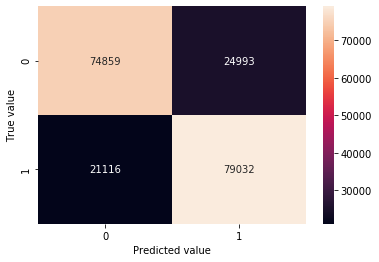

In [39]:
compute_metrics(model_tfidf, X, y)

In [58]:
def mapping(x): 
    if x == 4:
        return 1
    return 0

In [135]:
def precision_recall_vs_threshold(model, X, y, threshold=False):
    y_mapped = y.map(lambda x: mapping(x)) # Conventionally, postive class is 1
    y_scores = cross_val_predict(model, X, y, cv=skf, method='predict_proba') # method depends on chosen algorithm

    # this will do cross validation and then return the probabily of each class in that sample
    precisions, recalls, thresholds = precision_recall_curve(y_mapped, y_scores[:, 1])
    plt.plot(thresholds, precisions[:-1], 'r--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'b--', label='Recall')
    plt.xlabel('Thresholds')
    plt.legend(loc='best')
    plt.ylim([0, 1.1])

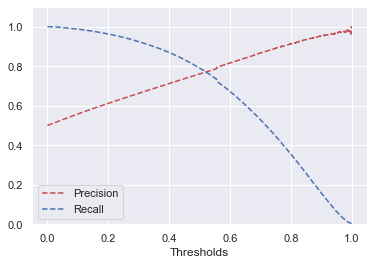

In [136]:
precision_recall_vs_threshold(model_tfidf, X, y)

<li> Precision = TP / (TP + FP)
<li> Recall = TP / (TP + FN)

Plot shows the trade-off between precision and recall, the high precision the low recall and vice versa

<strong> Which one should you choose ?

So it really depends on the situation. For example, if you are dealing with reviews of customer and you don't want to miss out any negative reviews as you do listen and care for your customer's experiences, and you maybe ignore some positive reviews as it's oke because it's already positive and you don't need to pay attention

Therefore, <strong> high precision </strong> (low FP)  and <strong> low recall </strong> (high FN) would definitely be a choice

According to the above plot, <strong> Threshold = 0.8 </strong> would gives you this alternative

In [41]:
y_pred = cross_val_predict(model_tfidf, X, y, cv=skf, method='predict_proba')[:, 1] > 0.8

In [56]:
def convert_4_to_1(x):
    return 1 if x == 4 else 0

precision_score: 0.91170473609498
recall_score: 0.35271797739345767
f1_score: 0.5086505439438992


[]

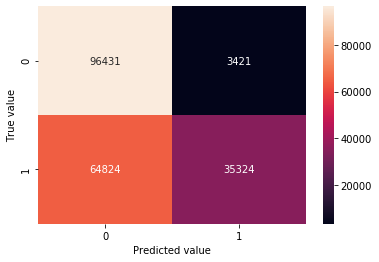

In [43]:
y_pred = y_pred.astype('int')
y = y.map(lambda x: convert_4_to_1(x))
print(f'precision_score: {precision_score(y, y_pred)}')
print(f'recall_score: {recall_score(y, y_pred)}')
print(f'f1_score: {f1_score(y, y_pred,)}')
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt='.5g')
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.plot()

Clearly, changing the threshold will get you to the <strong>point</strong> where precision is <strong>high</strong> and recall is <strong>low</strong>

In [70]:
def plot_roc_curve_func(models, colors, vectorizers, X, y):
    for model, color, vect in zip(models, colors, vectorizers):
        y_mapped = y.map(lambda x: mapping(x))
        if vect == 'Linear Kernel':
            y_scores = cross_val_predict(model, X, y, cv=skf, method='decision_function')
            tpr, fpr, _ = roc_curve(y_mapped, y_scores)
            auc = roc_auc_score(y_mapped, y_scores)
        else:
            y_scores = cross_val_predict(model, X, y, cv=skf, method='predict_proba')
            tpr, fpr, _ = roc_curve(y_mapped, y_scores[:, 1])
            auc = roc_auc_score(y_mapped, y_scores[:, 1])
        plt.plot(tpr, fpr, color, label= f'AUC {vect} = {auc:.2f}')
        
    plt.xlabel('False Positive Rate(1 - Specificity)')
    plt.ylabel('True Positive Rate(Recall)')
    plt.legend(loc='best')

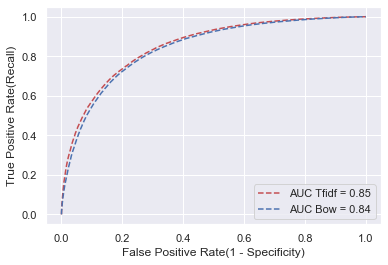

In [138]:
colors = ['r--', 'b--']
models = [model_tfidf, model_bow]
vectorizers = ['Tfidf', 'Bow']
plot_roc_curve_func(models, colors, vectorizers, X, y)

Comparing two models, Tfidf is <strong> slightly better</strong> than bag of words.
<li> ROC Curve is metrics to evaluate how the <strong>model perform</strong>(TPR on y-axis, FPR on x-axis)
<li> Clearly, which model tends to be <strong>higher to upper left</strong> is more substantial (high TPR and low FPR)

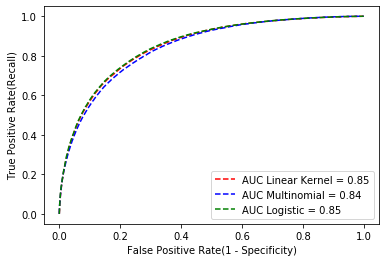

In [71]:
colors = ['r--', 'b--', 'g--']
models = [linear_kernel_pipeline, multinomial_pipeline, log_reg]
vectorizers = ['Linear Kernel', 'Multinomial', 'Logistic']
plot_roc_curve_func(models, colors, vectorizers, X, y)

In [51]:
tweets = pd.DataFrame(
    ['Today the weather is quite bad. I will not go outside.',
     
    'How awesome it is to play with you',
     
    'A Democrat win in 2020 would be a tragic setback for African Americans',
     
    'Our Coronavirus testing is so much greater (25 million tests) and so much more advanced, that it\
     makes us look we have more cases, especially proportionally, than other countries.\
     My message on that is very clear.'], 
    
     columns=['text'])

In [19]:
model_tfidf.predict(tweets)

array([0, 4, 0, 4])

## END.